# Generative AI - Actionable agents based on Large Language Model reasoning


## Requirements

In [ ]:
!apt install -qq -y lynx

In [ ]:
!pip -q install langchain==0.0.200
!pip -q install google-cloud-aiplatform==1.25.0

Restart the runtime after all the tools have been installed successfully.

## Connecting to Google Cloud project

Use one of the following credentials to authenticate:




In [3]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

Select project ``xebia-ai-training``

In [ ]:
!gcloud config set project xebia-ai-training

## Loading an LLM from AI platform

AI platform is Google's product for machine learning projects.

In [5]:
from google.cloud import aiplatform

PROJECT_ID = 'xebia-ai-training'
REGION = 'us-central1'

aiplatform.init(project=PROJECT_ID, location=REGION)

``text-bison@001`` is Google's VertexAI Pathways Language Model (PaLM).

Parameters of ``text-bison@001``:

- ``max_output_tokens``: The maximum amount of text output from one prompt, ranging from ``1`` to ``1024`` *tokens*.
  - A *token* is approximately four characters. The default value is 256.

- ``temperature``: The degree of randomness, ranging from ``0`` to ``1``.
  - Lower temperatures lead to more *truthful* responses
  - Higher temperatures can lead to more *confabulated* (and less truthful) responses.
  - A temperature of ``0`` is deterministic: the highest probability token is always selected.

- ``top_p``: Probability threshold for selecting tokens for output, ranging from ``0`` to ``1``. Default is ``0.8``.
  - Selection is based on the tokens with highest probabilities, where ``cumulative_sum <= top_p``.
  - For example, for ``top_p=0.5``: <table>
  <tr>
    <th>Token</th>
    <th>Probability</th>
    <th>Cumulative sum</th>
  </tr>
  <tr>
    <td>A</td>
    <td>0.3</td>
    <td>0.3</td>
  </tr>
  <tr>
    <td>B</td>
    <td>0.2</td>
    <td>0.5</td>
  </tr>
  <tr><td colspan="3"> --- Select from <b>ABOVE</b> using <code>temperature</code> --- </td></tr>
  <tr>
    <td>C</td>
    <td>0.1</td>
    <td>0.6</td>
  </tr>
  </table>


- ``top_k``: How many tokens are likely to be selected output, ranging from ``1`` to ``40`` (default).
  - When ``top-k==1``: the selected token is the most probable among all tokens in the model's vocabulary (greedy decoding).
  - When ``top-k==3``: the next token is selected from among the 3 most probable tokens (using ``temperature``).


More information in a GUI tool can be found [here](https://console.cloud.google.com/vertex-ai/generative/language/create/text?project=xebia-ai-training).

In [6]:
from langchain.llms import VertexAI

llm = VertexAI(
  model_name='text-bison@001',
  max_output_tokens=256,
  temperature=0.0,
  top_p=0.2,
  top_k=20,
  verbose=True
)

In [ ]:
llm("Good morning!")

## Exercise 1 - Determinism

So far it seems that the LLM has been acting in a **deterministic** way. What adjustments would you make so it sounds **less** robotic?

Tips:
- check out the parameter descriptions in the [previous section](#scrollTo=iSQymoxRLAJy) and find out how it affects the LLM's behavior.

- Use the cell from the previous section to tweak the parameters upon ``VertexAI()`` instantiation.

In [ ]:
llm("Tell me a joke")

## Exercise 2 - Functional limitations

As a reasoning engine, there is only so much an LLM can do. Try carrying out the following tasks:

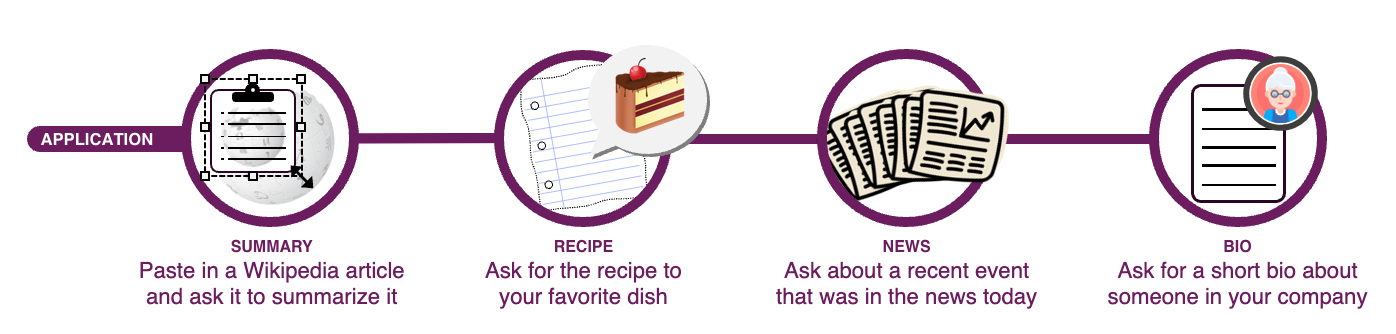

In [ ]:
# Trying to solve Math problem

math = "29^0.32"
print(math,"- llm result:", llm(math))
print(math,"- python result:", eval(math.replace("^","**")))

In [ ]:
# Summarizing wikipedia article

link = "https://en.wikipedia.org/wiki/Shepperds_pie"
output = llm(f"Summarize the contents of {link}")
print(output)

In [ ]:
# Asking for the recipe of a delicious Carbonara

output = llm("Give me a carbonara recipe")
print(output)

In [ ]:
# Asking about recent events

output = llm("What's on the dutch news for Jun 22nd 2023?")
print(output)

In [ ]:
# Bio
name = "INSERT THE NAME OF SOMEONE YOU KNOW"
output = llm(f"Write a short bio about {name}.")
print(output)

Based on the experience you had so far, quickly discuss with your peers:

- What are LLMs bad for?
- What are LLMs good for?
- How can we take the power of LLMs to the next level?

## Chaining

Large language models (LLMs) are emerging as a transformative technology, enabling developers to build applications that they previously could not. However, using these LLMs in isolation is often insufficient for creating a truly powerful app - the real power comes when you can combine them with other sources of computation or knowledge.

### Chaining

Chaining is about breaking down major tasks/prompts into smaller ones. It simplifies the process of reasoning/infromation retrieval, so all preliminary outputs can be combined towards crafting the final answer.

It enhances the power of LLMs, which can be leveraged in many application contexts, such as:

- Enriching Context towards question answering
- Information retrieval search
- **Actionable AI**

## Actionable AI

The Plan-and-execute [chain](https://python.langchain.com/docs/modules/agents/agent_types/plan_and_execute) is inspired in the "[Plan-and-solve](https://arxiv.org/abs/2305.04091)" paper. Such a method basically consists of two components: first, devising a plan to divide the entire task into smaller subtasks, and then carrying out the subtasks according to the plan.

In [23]:
from langchain.chat_models import ChatVertexAI
from langchain.experimental.plan_and_execute import PlanAndExecute, load_agent_executor, load_chat_planner
from langchain.agents.tools import Tool

### Adding Math tool

In [24]:
from langchain import LLMMathChain
llm_math_chain = LLMMathChain.from_llm(llm=llm, verbose=True)

calc_tool = Tool(
    name="Calculator",
    func=llm_math_chain.run,
    description="useful for when you need to answer questions about math operations"
)

In [25]:
model = ChatVertexAI(temperature=0)

def llm_agent(tools, prompt):
  planner = load_chat_planner(model)
  executor = load_agent_executor(model, tools, verbose=True, include_task_in_prompt=True)
  agent = PlanAndExecute(planner=planner, executor=executor, verbose=True)
  return agent.run(prompt)

In [ ]:
llm_agent(tools=[calc_tool], prompt=f"What is 29**0.32?")

In [190]:
29**0.32

2.9374288726044844

### Adding Google Search tool

Let's give a harder task to the current LLM agent:

"*Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power*?"

In [ ]:
llm_agent(
    tools=[calc_tool],
    prompt="Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?"
)

It still needs more actions to the outside world. In this case, an **information retrieval** strategy (Google search, for example) would be enough.

The cell below uses web scraping tools to get the contents of a website (``link2txt`` function), so we can use a Google search and an LLM to do the final reasoning on the results and determine which information to retrieve.

In [28]:
import subprocess
import re

def link2txt(link, truncate=20000):
  try:
    output = subprocess.check_output(
      [
        'lynx',
        '--useragent',
        'MOT-L7/NA.ACR_RB MIB/2.2.1 Profile/MIDP-2.0 Configuration/CLDC-1.1',
        '--nolist',
        '--nomargins',
        '--nonumbers',
        '--dump',
        link.replace("https://","http://")
      ]
    ).decode('utf-8')

    return "\n".join(
      [
        re.sub("[^a-zA-Z0-9.,()\[\]\"' /]","",row) for row in output.split("\n")
        if not re.match("^[ ]*[^0-9A-Za-z]",row)
      ]
    )[:truncate]
  except:
    return "This is not a valid website. Try again with another tool."


def google_search(search_str):
  res = link2txt(f"https://www.google.com/search?hl=en&num=5&q={search_str.replace(' ','%20')}")
  return llm(f"Extract information from the search results below and answer the following as concise as possible: {search_str}.\n\n{res}")

Now try retrieving information in two ways:

* ``google_search`` function
* ``llm`` function

In [29]:
prompt = "Who is <TRY INSERTING YOUR NAME HERE>"

In [ ]:
google_search(prompt)

In [ ]:
llm(prompt)

Now let's add the google search as a tool for the chaining strategy:

In [32]:
llm_math_chain = LLMMathChain.from_llm(llm=llm, verbose=True)

search_tool = Tool(
    name = "Search",
    func=google_search,
    description="useful for when you need to answer questions about current events. If you don't know, using 'what is' as part of the search can be helpful."
)

calc_tool = Tool(
    name="Calculator",
    func=llm_math_chain.run,
    description="useful for when you need to answer questions about math operations"
)


And back to our main question:

In [ ]:
llm_agent(
    tools=[search_tool, calc_tool],
    prompt="Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?"
)

### Bonus - Create your own tool

We still have our browser tool we can make use of! Possibilities are endless:
- Try making a tool of your own with it, or
- Create a python function of your own that can be useful for any specific case, or
- Incorporate ``link2txt()`` or ``google_search()`` function as part of your own code, or
- Combine your own tool with the previous ones available, or
- Any cool stuff that comes up in your mind

Have fun!

In [ ]:
def my_func(input_txt):
  return "output_txt"

my_tool = Tool(
    name="Tool",
    func=my_func,
    description="useful for a particular case you can describe in a precise way here. Remember this is still prompt engineering."
)

In [ ]:
llm_agent(
    tools=[my_tool],
    prompt="This is a prompt"
)